In [1]:
%load_ext autoreload
%autoreload 2

# Dataset preparing

In [2]:
from dataset.fact_dataset_generator import FactDatasetGenerator
import numpy as np
import sys
import pandas as pd

In [3]:
true_dist_size = 1000
dataset = FactDatasetGenerator(number_person=100,  distribution="zipf", dataset_folder='./dataset/data/', food_list_name="food_list_small.txt",true_dist_size=true_dist_size)

In [4]:
# Generate all possible facts
temp = dataset.generate_all_possibilities()

In [5]:
len(temp)

10100

In [6]:
# Sample true dist (zipf)
true_dist = dataset.generate_true_dist()

In [7]:
true_dist_df = pd.DataFrame(true_dist,columns=["facts"])

In [8]:
true_dist_df

,facts
0,"Bendite,beef tartare"
1,"El,carrot cake"
2,"Shaina,gyoza"
3,"Rossy,samosa"
4,"Shaun,club sandwich"
...,...
995,"Flore,pad thai"
996,"Violetta,club sandwich"
997,"Mirilla,donuts"
998,"Farly,ravioli"


In [9]:
true_duplicates_count = true_dist_df.groupby(list(true_dist_df.columns)).size().reset_index(name='count_true')


In [10]:
true_duplicates_count

,facts,count_true
0,"Albertine,apple pie",1
1,"Albertine,beef tartare",1
2,"Albertine,french fries",1
3,"Albertine,ice cream",1
4,"Albertine,spaghetti carbonara",1
...,...,...
507,"Winfield,tiramisu",1
508,"Xenos,baklava",1
509,"Xenos,french toast",3
510,"Zeb,cheese plate",1


In [11]:
# Sample training data uniformly, %80 of true dist
training_dataset_size = int(0.8 * true_dist_size)
training_data = dataset.sample_training_data(training_dataset_size,true_dist.tolist())

In [12]:
training_dist_df = pd.DataFrame(training_data,columns=["facts"])
training_duplicates_count = training_dist_df.groupby(list(training_dist_df.columns)).size().reset_index(name='count_train')

In [13]:
training_duplicates_count

,facts,count_train
0,"Albertine,french fries",1
1,"Albertine,ice cream",1
2,"Albertine,spaghetti carbonara",1
3,"Archibald,omelette",2
4,"Archibald,pizza",1
...,...,...
418,"Winfield,seaweed salad",1
419,"Winfield,tiramisu",1
420,"Xenos,baklava",1
421,"Xenos,french toast",3


In [14]:
import torch
## get the training  datasets
train_dataset = [torch.tensor(x, dtype=torch.long) for x in dataset.tokenized_training_data]


In [15]:
from torch.utils.data import Dataset

## create a dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming each item in data is a sequence and we use the same sequence shifted by one as the target
        x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
        y = torch.tensor(self.data[idx][1:], dtype=torch.long)
        #print(x)
        #print(y)
        
        return x, y


## create the datasets
train_data = MyDataset(train_dataset)
# test_data = MyDataset(test_dataset)

print(train_data)

# Model preparing

In [16]:
## import mingpt
sys.path.append('minGPT/')
from mingpt.model import GPT
from mingpt.utils import set_seed
set_seed(42)

model_config = GPT.get_default_config()
model_config.n_layer=12
model_config.n_head=8
model_config.n_embd=512
model_config.vocab_size = dataset.vocab_size
model_config.model_type = None
model_config.block_size = 2

# model_config.model_type = 'gpt-nano'
# model_config.vocab_size = dataset.vocab_size
# model_config.block_size = 2

model = GPT(model_config)

number of parameters: 0.09M


In [21]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 10000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_data)

running on device cpu


# Training the model

In [23]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 100:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

/tmp/ipykernel_5371/3675710179.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
/tmp/ipykernel_5371/3675710179.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.data[idx][1:], dtype=torch.long)


iter_dt 0.98ms; iter 0: train loss 4.07869
iter_dt 0.87ms; iter 100: train loss 4.00980
iter_dt 0.87ms; iter 200: train loss 3.93547
iter_dt 0.89ms; iter 300: train loss 3.88888
iter_dt 0.95ms; iter 400: train loss 3.90022
iter_dt 1.05ms; iter 500: train loss 3.59004
iter_dt 0.88ms; iter 600: train loss 3.91746
iter_dt 0.92ms; iter 700: train loss 3.83147
iter_dt 0.92ms; iter 800: train loss 3.65165
iter_dt 0.92ms; iter 900: train loss 3.65699
iter_dt 0.92ms; iter 1000: train loss 3.74595
iter_dt 0.92ms; iter 1100: train loss 3.50246
iter_dt 0.92ms; iter 1200: train loss 3.70482
iter_dt 0.93ms; iter 1300: train loss 3.60048
iter_dt 0.95ms; iter 1400: train loss 3.63867
iter_dt 0.95ms; iter 1500: train loss 3.28485
iter_dt 0.93ms; iter 1600: train loss 3.36952
iter_dt 0.93ms; iter 1700: train loss 3.26255
iter_dt 0.95ms; iter 1800: train loss 3.23694
iter_dt 0.93ms; iter 1900: train loss 3.45602
iter_dt 0.92ms; iter 2000: train loss 3.46443
iter_dt 0.94ms; iter 2100: train loss 3.31916


In [24]:
# now let's perform some evaluation
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(201, 48)
    (wpe): Embedding(2, 48)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x Block(
        (ln_1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=48, out_features=144, bias=True)
          (c_proj): Linear(in_features=48, out_features=48, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=48, out_features=192, bias=True)
          (c_proj): Linear(in_features=192, out_features=48, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=48, out_

# Generate unconditioned facts

In [25]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [27]:
n_sequences = 1000
from collections import defaultdict
collected_generations = []

for _ in range(n_sequences):
    x = torch.Tensor([0]).unsqueeze(0).long().to("cpu")
    y_gen = model.generate(x, 2, do_sample=True)
    name = food_item = dataset.decode([y_gen[0][1]])[0]
    food_item = dataset.decode([y_gen[0][2]])[0]
    collected_generations.append(f"{name},{food_item}")

In [28]:
collected_generations_df = pd.DataFrame(collected_generations, columns=["facts"])

In [29]:
collected_generations_counts = collected_generations_df.groupby(list(collected_generations_df.columns)).size().reset_index(name='count_generated')


In [30]:
collected_generations_counts

,facts,count_generated
0,"Albertine,ice cream",1
1,"Archibald,fried rice",1
2,"Archibald,strawberry shortcake",1
3,"Arlen,chocolate cake",4
4,"Astrix,baby back ribs",2
...,...,...
386,"oysters ,tiramisu",1
387,"spaghetti carbonara ,hummus",1
388,"steak ,bibimbap",1
389,"sushi ,poutine",1


In [31]:
# Merge true dist and training dist dataframes, outer is used to include data that is not in training data as well
merged_df = pd.merge(true_duplicates_count, training_duplicates_count, on='facts', how='outer')

In [32]:
# Add generated_df to true and training dfs 
# outer can be used to include all facts in true dist
# inner can be used to only show the comparison of generated facts
comparison_df = pd.merge(merged_df, collected_generations_counts, on='facts', how='outer')

In [33]:
comparison_df

,facts,count_true,count_train,count_generated
0,"Albertine,apple pie",1.0,NaN,NaN
1,"Albertine,beef tartare",1.0,NaN,NaN
2,"Albertine,french fries",1.0,1.0,NaN
3,"Albertine,ice cream",1.0,1.0,1.0
4,"Albertine,spaghetti carbonara",1.0,1.0,NaN
...,...,...,...,...
641,"oysters ,tiramisu",NaN,NaN,1.0
642,"spaghetti carbonara ,hummus",NaN,NaN,1.0
643,"steak ,bibimbap",NaN,NaN,1.0
644,"sushi ,poutine",NaN,NaN,1.0


In [34]:
# Fill in 0 for facts that not appear
comparison_df = comparison_df.fillna(0)

In [35]:
# Normalize the counts by length
comparison_df["count_generated"] = comparison_df['count_generated']/len(collected_generations)
comparison_df["count_train"] = comparison_df['count_train']/len(training_data)
comparison_df["count_true"] = comparison_df['count_true']/len(true_dist)


In [40]:
comparison_df = comparison_df.sort_values(by=['count_generated'], ascending=False)

In [41]:
comparison_df

,facts,count_true,count_train,count_generated
180,"Flore,pad thai",0.112,0.11250,0.135
323,"Mirilla,donuts",0.059,0.06375,0.054
425,"Shaun,club sandwich",0.046,0.03875,0.052
198,"Gustaf,hot dog",0.015,0.01500,0.022
118,"Dyana,spring rolls",0.019,0.02000,0.018
...,...,...,...,...
243,"Juliana,chicken quesadilla",0.001,0.00125,0.000
426,"Shaun,fried rice",0.001,0.00000,0.000
244,"Juliana,chocolate mousse",0.002,0.00125,0.000
424,"Shaun,ceviche",0.002,0.00125,0.000


In [65]:
comparison_df.sum()

facts              Flore,pad thai Mirilla,donuts Shaun,club sandw...
count_true                                                       1.0
count_train                                                      1.0
count_generated                                                  1.0
dtype: object

<Axes: >

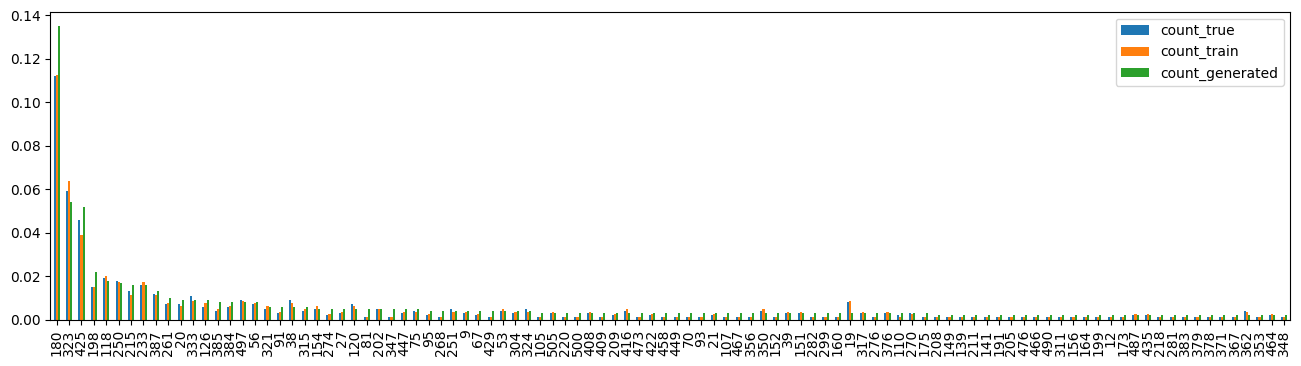

In [42]:
import matplotlib.pyplot as plt
import numpy as np
# Only the top 100 facts graphed for visibility 
comparison_df[:100].plot.bar(figsize=(16, 4))

## Hallucination rates

In [43]:
# True hallucination rate (generations not in true dist)
true_hallucinations = pd.merge(collected_generations_counts, true_duplicates_count, on='facts', how='left')


In [44]:
true_hallucinations

,facts,count_generated,count_true
0,"Albertine,ice cream",1,1.0
1,"Archibald,fried rice",1,NaN
2,"Archibald,strawberry shortcake",1,NaN
3,"Arlen,chocolate cake",4,3.0
4,"Astrix,baby back ribs",2,1.0
...,...,...,...
386,"oysters ,tiramisu",1,NaN
387,"spaghetti carbonara ,hummus",1,NaN
388,"steak ,bibimbap",1,NaN
389,"sushi ,poutine",1,NaN


In [45]:
true_hallucinations = true_hallucinations.fillna(0)
number_of_true_hallucinations =true_hallucinations["count_true"].value_counts()[0]
true_hallucinations_rate = number_of_true_hallucinations / len(collected_generations)
print(f"Rate of true hallucinations: {true_hallucinations_rate} ")

Rate of true hallucinations: 0.134 


In [46]:
# Naive hallucination rate (every generation not in training data)
naive_hallucinations = pd.merge(collected_generations_counts, training_duplicates_count, on='facts', how='left')

In [47]:
naive_hallucinations

,facts,count_generated,count_train
0,"Albertine,ice cream",1,1.0
1,"Archibald,fried rice",1,NaN
2,"Archibald,strawberry shortcake",1,NaN
3,"Arlen,chocolate cake",4,3.0
4,"Astrix,baby back ribs",2,1.0
...,...,...,...
386,"oysters ,tiramisu",1,NaN
387,"spaghetti carbonara ,hummus",1,NaN
388,"steak ,bibimbap",1,NaN
389,"sushi ,poutine",1,NaN


In [48]:
naive_hallucinations = naive_hallucinations.fillna(0)
number_of_naive_hallucinations = naive_hallucinations["count_train"].value_counts()[0]
naive_hallucinations_rate = number_of_naive_hallucinations / len(collected_generations)
print(f"Rate of naive hallucinations: {naive_hallucinations_rate} ")

Rate of naive hallucinations: 0.135 


### Monofact rate

In [48]:
training_duplicates_count["count_train"].value_counts()[1] / len(training_data)

0.43875

In [59]:
training_duplicates_count["count_train"].value_counts()[1]

351

### Miscalibration

In [77]:
from lib.calibration import miscalibration

In [78]:
comparison_sorted_by_generated = comparison_df.sort_values(by='count_generated', ascending=False)

In [79]:
miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_true'])

Adaptive binning with 7 bins
bin with g_proba / p_proba 0.135 0.112
bin with g_proba / p_proba 0.128 0.12
bin with g_proba / p_proba 0.141 0.12800000000000003
bin with g_proba / p_proba 0.14000000000000004 0.108
bin with g_proba / p_proba 0.14100000000000007 0.083
bin with g_proba / p_proba 0.1420000000000001 0.09100000000000003
bin with g_proba / p_proba 0.1420000000000001 0.07300000000000001
bin with g_proba / p_proba 0.03100000000000002 0.28500000000000003


0.28915005827505835

In [81]:
miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_train'])

Adaptive binning with 7 bins
bin with g_proba / p_proba 0.135 0.1125
bin with g_proba / p_proba 0.128 0.11750000000000001
bin with g_proba / p_proba 0.141 0.12750000000000003
bin with g_proba / p_proba 0.14000000000000004 0.11875000000000001
bin with g_proba / p_proba 0.14100000000000007 0.10124999999999999
bin with g_proba / p_proba 0.1420000000000001 0.10750000000000001
bin with g_proba / p_proba 0.1420000000000001 0.0875
bin with g_proba / p_proba 0.03100000000000002 0.22750000000000004


0.23978101325757578

### Check if it holds

In [24]:
unique_names = len(set([t[1] for t in train_dataset]))
unique_foods = len(set([t[2] for t in train_dataset]))
# Possible generations
POSS_GENERATIONS = unique_names * unique_foods

# Facts to all possibilities - facts, approximated
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS = 300 * len(training_duplicates_count) / (POSS_GENERATIONS - len(training_duplicates_count))

In [21]:
HALLUCINATION_RATE = 0.134

MF = 0.43875

MISCALIBRATION = 0.2891

In [25]:
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

0.1984123881878179

In [85]:
MF - MISCALIBRATION

0.14964999999999995

In [90]:
7 / np.sqrt(len(training_data))

0.24748737341529162

In [26]:
MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

-0.29624976160310956

In [27]:
HALLUCINATION_RATE

0.134

In [28]:
HALLUCINATION_RATE > MF - MISCALIBRATION

False

In [29]:
HALLUCINATION_RATE > MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

True